# Numerical Solvers for Ordinary Differential Equations

@[Chaoming Wang](mailto:chao.brain@qq.com)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

Brain modeling toolkit provided in BrainPy is focused on **differential equations**. How to solve differential equations is the essence of the neurodynamics simulation. The exact algebraic solutions are only available for low-order differential equations. For the coupled high-dimensional non-linear brain dynamical systems, we need to resort to numerical methods for solving such differential equations. 

This section will illustrate how to define ordinary differential quations (ODEs) and how to define the numerical integration methods for ODEs in BrainPy.

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

bm.set_platform('cpu')

%matplotlib inline

## How to define ODE functions?

BrainPy provides a convenient and intuitive way to define ODE systems. For the ODEs

$$
{dx \over dt} = f_1(x, t, y, p_1)\\
{dy \over dt} = g_1(y, t, x, p_2)
$$

we can define them in a Python function: 

In [2]:
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

where `t` denotes the current time, `x` and `y` passed before `t` denote the dynamical variables, and `p1` and `p2` after `t` denote the parameters needed in this system. In the function body, the derivative `f1` and `g1` can be customized by the user's need. Finally, the corresponding derivatives `dx` and `dy` are returned in the same order as that of the variables in the function arguments.

For each variabl, it can be a scalar (`var_type = bp.integrators.SCALAR_VAR`), a vector/matrix (`var_type = bp.integrators.POP_VAR`), or a system (`var_type = bp.integrators.SYSTEM_VAR`). The "system" means that the argument `x` denotes an array of variables. Take the above example as the demonstration again, we can redefine it as:

In [3]:
def diff(xy, t, p1, p2):
    x, y = xy
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return bm.array([dx, dy])

## How to define the numerical integration for ODEs?

After the definition of ODE functions, it is very easy to define the numerical integration for these functions. We just need to put a decorator `bp.odeint` above the ODE function. 

In [4]:
@bp.odeint
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

After wrapping it by ``bp.odeint``, the function becomes an instance of ``ODEintegrator``.

In [5]:
isinstance(diff, bp.ode.ODEIntegrator)

True

`bp.odeint` receives several arguments:

- **"method"**: A string, used to specify the numerical methods to integrate the ODE functions. The default method is [Euler](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst).

In [6]:
diff

- **"dt"**: A float, used to set the default numerical precision. The default "dt" is 0.1. 

In [7]:
diff.dt

0.1

- **"show_code"**: bool, to indicate whether to show the numerical integration code. Let's take [Euler method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst) and [RK4 method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.RK4.rst) as the illustrated examples.

In [8]:
@bp.odeint(method='euler', show_code=True, dt=0.01)
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

diff

def brainpy_itg_of_ode1_diff(x, y, t, p1, p2, dt=0.01):
  dx_k1, dy_k1 = f(x, y, t, p1, p2)
  x_new = x + dx_k1 * dt * 1
  y_new = y + dy_k1 * dt * 1
  return x_new, y_new

{'f': <function diff at 0x0000017FE2BABEE0>}



In [9]:
@bp.odeint(method='rk4', show_code=True, dt=0.1)
def diff(x, y, t, p1, p2):
    dx = f1(x, t, y, p1)
    dy = g1(y, t, x, p2)
    return dx, dy

diff

def brainpy_itg_of_ode2_diff(x, y, t, p1, p2, dt=0.1):
  dx_k1, dy_k1 = f(x, y, t, p1, p2)
  k2_x_arg = x + dt * dx_k1 * 0.5
  k2_y_arg = y + dt * dy_k1 * 0.5
  k2_t_arg = t + dt * 0.5
  dx_k2, dy_k2 = f(k2_x_arg, k2_y_arg, k2_t_arg, p1, p2)
  k3_x_arg = x + dt * dx_k2 * 0.5
  k3_y_arg = y + dt * dy_k2 * 0.5
  k3_t_arg = t + dt * 0.5
  dx_k3, dy_k3 = f(k3_x_arg, k3_y_arg, k3_t_arg, p1, p2)
  k4_x_arg = x + dt * dx_k3
  k4_y_arg = y + dt * dy_k3
  k4_t_arg = t + dt
  dx_k4, dy_k4 = f(k4_x_arg, k4_y_arg, k4_t_arg, p1, p2)
  x_new = x + dx_k1 * dt * 1/6 + dx_k2 * dt * 1/3 + dx_k3 * dt * 1/3 + dx_k4 * dt * 1/6
  y_new = y + dy_k1 * dt * 1/6 + dy_k2 * dt * 1/3 + dy_k3 * dt * 1/3 + dy_k4 * dt * 1/6
  return x_new, y_new

{'f': <function diff at 0x0000017FE2BCA430>}



## Two Examples

### Example 1: FitzHugh–Nagumo model

Now, let's take the well known [FitzHugh–Nagumo model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model) as an exmaple to illustrate how to define ODE solvers for brain modeling. The FitzHugh–Nagumo model (FHN) model has two dynamical variables, which are governed by the following equations:

$$
\begin{split}
\tau {\dot  {w}}&=v+a-bw\\
{\dot {v}} &=v-{\frac {v^{3}}{3}}-w+I_{\rm {ext}}
\end{split}
$$

For this FHN model, we can code it in BrainPy like this:

In [10]:
@bp.odeint(dt=0.01)
def integral(V, w, t, Iext, a, b, tau):
    dw = (V + a - b * w) / tau
    dV = V - V * V * V / 3 - w + Iext
    return dV, dw

After defining the numerical solver, the solution of the ODE system in the given times can be easily solved. For example, for the given parameters,

In [11]:
a = 0.7;   b = 0.8;   tau = 12.5;   Iext = 1.

the solution of the FHN model between 0 and 100 ms can be approximated by 

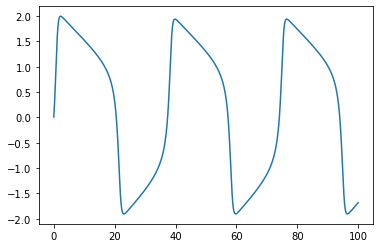

In [12]:
hist_times = bm.arange(0, 100, 0.01)
hist_V = []
V, w = 0., 0.
for t in hist_times:
    V, w = integral(V, w, t, Iext, a, b, tau)
    hist_V.append(V)

plt.plot(hist_times, hist_V)
plt.show()

This manual loop in Python code is usually slow. In BrainPy, we provide a structural runner for integrators: ``brainpy.integrators.IntegratorRunner``, which can benefit from the [JIT compilation](../tutorial_basics/jit_compilation.ipynb).

  0%|          | 0/10000 [00:00<?, ?it/s]

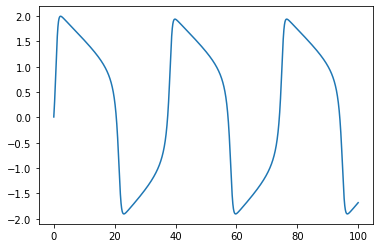

In [13]:
runner = bp.integrators.IntegratorRunner(
    integral,
    monitors=['V'],
    inits=dict(V=0., w=0.),
    args=dict(a=a, b=b, tau=tau, Iext=Iext),
    dt=0.01
)
runner.run(100.)

plt.plot(runner.mon.ts, runner.mon.V)
plt.show()

### Example 2: Hodgkin–Huxley model

Another more complex example is the classical [Hodgkin–Huxley neuron model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model). In HH model, four dynamical variables (`V, m, n, h`) are used for modeling the initiation and propagation of the action potential. Specifically, they are governed by the following equations:

$$
\begin{aligned}
C_{m} \frac{d V}{d t} &=-\bar{g}_{\mathrm{K}} n^{4}\left(V-V_{K}\right)- \bar{g}_{\mathrm{Na}} m^{3} h\left(V-V_{N a}\right)-\bar{g}_{l}\left(V-V_{l}\right)+I_{s y n} \\
\frac{d m}{d t} &=\alpha_{m}(V)(1-m)-\beta_{m}(V) m \\
\frac{d h}{d t} &=\alpha_{h}(V)(1-h)-\beta_{h}(V) h \\
\frac{d n}{d t} &=\alpha_{n}(V)(1-n)-\beta_{n}(V) n
\end{aligned}
$$

In BrainPy, such dynamical system can be coded as:

In [14]:
@bp.odeint(method='rk4', dt=0.01)
def integral(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

Same as the FHN model, we can also integrate the HH model in the given parameters and time interval:

In [15]:
Iext = 10.;   ENa = 50.;   EK = -77.;   EL = -54.387
C = 1.0;      gNa = 120.;  gK = 36.;    gL = 0.03

  0%|          | 0/10000 [00:00<?, ?it/s]

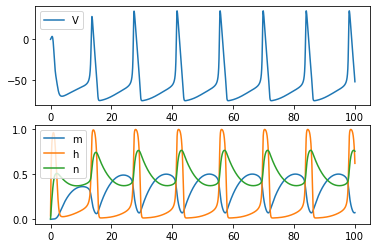

In [16]:
runner = bp.integrators.IntegratorRunner(
    integral,
    monitors=list('Vmhn'),
    inits=[0., 0., 0., 0.],
    args=dict(Iext=Iext, gNa=gNa, ENa=ENa, gK=gK, EK=EK, gL=gL, EL=EL, C=C),
    dt=0.01
)
runner.run(100.)

plt.subplot(211)
plt.plot(runner.mon.ts, runner.mon.V, label='V')
plt.legend()
plt.subplot(212)
plt.plot(runner.mon.ts, runner.mon.m, label='m')
plt.plot(runner.mon.ts, runner.mon.h, label='h')
plt.plot(runner.mon.ts, runner.mon.n, label='n')
plt.legend()
plt.show()

## Provided ODE Numerical Solvers

`BrainPy` provides several types of numerical methods for ODEs, including explicit Runge-Kutta methods, adaptive Runge-Kutta methods, and Exponential Euler methods.

### 1. Explicit Runge-Kutta (RK) methods for ODEs

The first category of ODE numerical integration support is the [explicit Runge-Kutta (RK) methods](../apis/integrators/ode_explicit_rk.rst). RK methods are a huge family of numerical methods with a wide variety of trade-offs: efficiency, accuracy, stability, etc. The supported RK methods are listed in the following table:

| Methods                                                 | Keywords    |
|-----------------------------------------------------|-------------|
| [Euler](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst) | euler       |
| [Midpoint](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.MidPoint.rst) | midpoint    |
| [Heun's second-order method](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.Heun2.rst) | heun2       |
| [Ralston's second-order method](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.Ralston2.rst) | ralston2    |
| [RK2](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.RK2.rst)| rk2         |
| [RK3](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.RK3.rst) | rk3         |
| [RK4](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.RK4.rst) | rk4         |
| [Heun's third-order method](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.Heun3.rst) | heun3       |
| [Ralston's third-order method](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.Ralston3.rst) | ralston3    |
| [Third-order Strong Stability Preserving Runge-Kutta](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.SSPRK3.rst) | ssprk3      |
| [Ralston's fourth-order method](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.Ralston4.rst) | ralston4    |
| [Runge-Kutta 3/8-rule fourth-order method](../apis/auto/integrators/generated/brainpy.integrators.ode.explicit_rk.RK4Rule38.rst)| rk4_38rule |

Users can utilize these methods by specifying the `method` option in `brainpy.odeint()` with their corresponding keyword. For example:

In [17]:
@bp.odeint(method='rk4')
def int_v(v, t, p):
    # do something
    return v

int_v

Or, you can directly instance your favorite integrator:

In [18]:
@bp.ode.RK4
def int_v(v, t, p):
    # do something
    return v

int_v

In [19]:
def derivative(v, t, p):
    # do something
    return v

int_v = bp.ode.RK4(derivative, dt=0.01)
int_v

### 2. Adaptive Runge-Kutta (RK) methods for ODEs

The second category of ODE numerical support is the [adaptive RK methods](../apis/integrators/ode_adaptive_rk.rst). What's different from the explicit RK methods is that adaptive methods are designed to produce an estimate of the local truncation error in a single Runge-Kutta step, then such error can be used to adaptively control the numerical step size. Specifically, if $error > tol$, then replace $dt$ with $dt_{new}$ and repeat the step. Therefore, adaptive RK methods allow a varied step size. In BrainPy, the following adaptive RK methods are provided in BrainPy:

| Methods                   | keywords    |
|---------------------------|-------------|
| [Runge–Kutta–Fehlberg 4(5)](../apis/auto/integrators/generated/brainpy.integrators.ode.adaptive_rk.RKF45.rst)  | rkf45       |
| [Runge–Kutta–Fehlberg 1(2)](../apis/auto/integrators/generated/brainpy.integrators.ode.adaptive_rk.RKF12.rst) | rkf12       |
| [Dormand–Prince method](../apis/auto/integrators/generated/brainpy.integrators.ode.adaptive_rk.DormandPrince.rst) | rkdp        |
| [Cash–Karp method](../apis/auto/integrators/generated/brainpy.integrators.ode.adaptive_rk.CashKarp.rst) | ck          |
| [Bogacki–Shampine method](../apis/auto/integrators/generated/brainpy.integrators.ode.adaptive_rk.BogackiShampine.rst) | bs          |
| [Heun–Euler method](../apis/auto/integrators/generated/brainpy.integrators.ode.adaptive_rk.HeunEuler.rst)  | heun_euler |

In default, the above methods are not adaptive, unless users provide a keyword `adaptive=True` in `brainpy.odeint()`. When users use the adaptive RK methods for numerical integration, the instantaneously adjusted stepsize `dt` will be appended in the functional arguments. Moreover, the tolerance `tol` for stepsize adjustment can also be modified. Let's take the Lorenz system as the example:

In [20]:
# adaptively adjust step-size

@bm.jit
@bp.odeint(method='rkf45', 
           adaptive=True, # active the "adaptive" option
           tol=0.001) # set the tolerance
def lorenz(x, y, z, t, sigma, beta, rho):
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return dx, dy, dz

In [21]:
times = bm.arange(0, 100, 0.01)
hist_x, hist_y, hist_z, hist_dt = [], [], [], []
x, y, z, dt = bm.array([1]), bm.array([1]), bm.array([1]), 0.05
for t in times:
    # should provide one more argument "dt" when using the adaptive rk method
    x, y, z, dt = lorenz(x, y, z, t, sigma=10, beta=8/3, rho=28, dt=dt)  
    hist_x.append(x.value)
    hist_y.append(y.value)
    hist_z.append(z.value)
    hist_dt.append(dt)
hist_x = bm.array(hist_x).flatten()
hist_y = bm.array(hist_y).flatten()
hist_z = bm.array(hist_z).flatten()
hist_dt = bm.array(hist_dt)

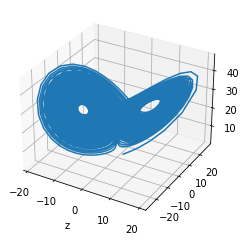

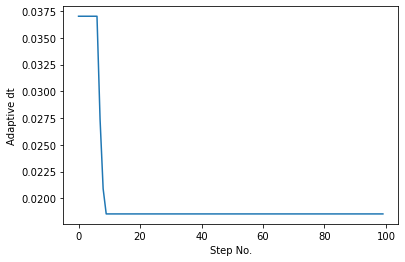

In [22]:
fig = plt.figure()
ax = plt.subplot(projection='3d')
plt.plot(hist_x, hist_y, hist_z)
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')

fig = plt.figure()
plt.plot(hist_dt[:100])
plt.xlabel('Step No.')
plt.ylabel('Adaptive dt')
plt.show()

### 3. Exponential Euler methods for ODEs

Finally, BrainPy provides Exponential integrators for ODEs. For you ODE systems, we highly recommend you to use Exponential Euler methods. Exponential Euler method provided in BrainPy uses automatic differentiation to find linear part.

| Methods           | keywords          |
|-------------------|-------------------|
| [Exponential Euler](../apis/auto/integrators/generated/brainpy.integrators.ode.exponential.ExpEulerAuto.rst) | exp_euler         |

Let's take a linear system as the theoretical demonstration,

$$
{dy \over dt} = A - By
$$

the exponential Euler schema is given by:

$$
y(t+dt) = y(t) e^{-B*dt} + {A \over B}(1 - e^{-B*dt})
$$

As you can see, for such linear systems, the exponential Euler schema is nearly the exact solution.

However, using Exponential Euler method requires us to write each derivative function separately. Otherwise, the automatic differentiation will lead to wrong results.


Interestingly, the computational expensive neuron model --- Hodgkin–Huxley model --- is a linear-like ODE system. You will find that by using the Exponential Euler method, the numerical step can be greatly enlarged to save the computation time.

$$
\begin{aligned}
C_{m}{\frac {d V}{dt}}&= -\left[{\bar {g}}_{\text{K}}n^{4} + {\bar {g}}_{\text{Na}}m^{3}h + {\bar {g}}_{l} \right] V  +{\bar {g}}_{\text{K}}n^{4} V_{K} + {\bar {g}}_{\text{Na}}m^{3}h V_{Na} + {\bar {g}}_{l} V_{l} + I_{syn} \\
{\frac {dm}{dt}} &= \left[-\alpha _{m}(V)-\beta _{m}(V)\right]m + \alpha _{m}(V) \\
{\frac {dh}{dt}} &= \left[-\alpha _{h}(V)-\beta _{h}(V)\right]h + \alpha _{h}(V) \\
{\frac {dn}{dt}} &= \left[-\alpha _{n}(V)-\beta _{n}(V)\right]n + \alpha _{n}(V) \\
\end{aligned}
$$

In [23]:
Iext=10.;   ENa=50.;   EK=-77.;   EL=-54.387
C=1.0;      gNa=120.;  gK=36.;    gL=0.03

In [24]:
def dm(m, t, V):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return dmdt

In [25]:
def dh(h, t, V):
    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return dhdt

In [26]:
def dn(n, t, V):
    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return dndt

In [27]:
def dV(V, t, m, h, n, Iext):
    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C
    return dVdt

Although we define HH differential equations as separable functions, relying on [brainpy.JointEq](./joint_equations.ipynb), we can numerically integrate these equations jointly.

In [28]:
hh_derivative = bp.JointEq([dV, dm, dh, dn])

In [29]:
def run(method, Iext=10., dt=0.1):
    integral = bp.odeint(hh_derivative, method=method)

    runner = bp.integrators.IntegratorRunner(
        integral,
        monitors=list('Vmhn'),
        inits=[0., 0., 0., 0.],
        args=dict(Iext=Iext),
        dt=dt
    )
    runner.run(100.)

    plt.subplot(211)
    plt.plot(runner.mon.ts, runner.mon.V, label='V')
    plt.legend()
    plt.subplot(212)
    plt.plot(runner.mon.ts, runner.mon.m, label='m')
    plt.plot(runner.mon.ts, runner.mon.h, label='h')
    plt.plot(runner.mon.ts, runner.mon.n, label='n')
    plt.legend()
    plt.show()

**Euler Method**: not able to complete the integral when the time step is a bit larger

  0%|          | 0/5000 [00:00<?, ?it/s]

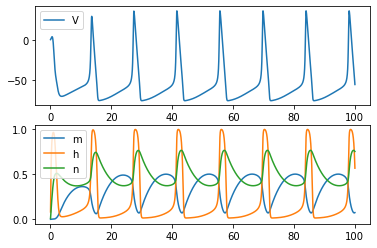

In [30]:
run('euler', Iext=10, dt=0.02)

  0%|          | 0/1000 [00:00<?, ?it/s]

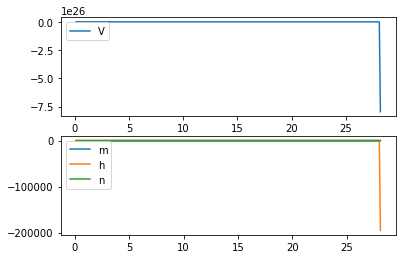

In [31]:
run('euler', Iext=10, dt=0.1)

**RK4 Method**: better than the Euler method, but still requires the times step to be small

  0%|          | 0/1000 [00:00<?, ?it/s]

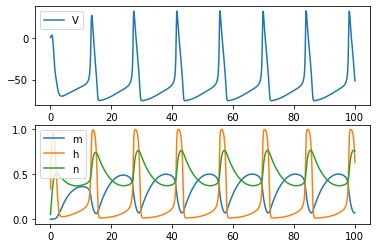

In [32]:
run('rk4', Iext=10, dt=0.1)

  0%|          | 0/500 [00:00<?, ?it/s]

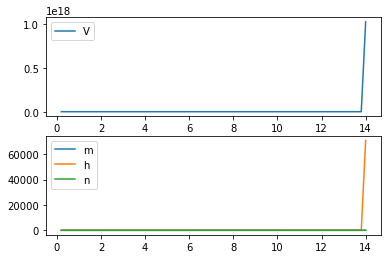

In [33]:
run('rk4', Iext=10, dt=0.2)

**Exponential Euler Method**: allows larger time step and generates accurate results

  0%|          | 0/500 [00:00<?, ?it/s]

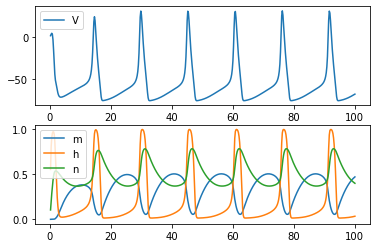

In [34]:
run('exp_euler', Iext=10, dt=0.2)